# XGBoost Model Training with Custom Loss Function - Baseline, for Icelandic Stake Data

In this notebook, a XGBoost model, with a custom loss function, is trained to predict the surface mass balance for glaciers in Iceland with a **monthly resolution**. This notebook sets the baseline that will be compared to the XGBoost model with transfer learning that was pre-trained with data from the Norwegian glaciers.

In [1]:
import sys
import os
import re
import os.path
import joblib

import pandas as pd

from re import match
from pathlib import Path

import xgboost
from sklearn.model_selection import GridSearchCV

sys.path.append('.././scripts-model-training')

from plotting_methods import *
from preparation_data import *
from model_methods import *
from custom_xgboost_regressor import CustomXGBoostRegressor

xgb.set_config(verbosity=0)

PLOTTING = False
RANDOM_SEED = 42
FILE_DIR = '.././data/files/'
FILE_NAME = 'Iceland_Stake_Data_Cleaned.csv'

## 1. Import the Dataset and Prepare the Data for Training, Testing, and Cross Validation

Remove the records with missing annual or seasonal surface mass balances, and randomly split the dataset for the annual and seasonal surface mass balances into a training and test dataset.  

**Note**: It is not necessary to split the dataset into training and testing sets based on the geographical location of the glaciers; random splitting is sufficient. In Norway, glaciers are distributed across varied geographical locations, but in Iceland, this distribution is relatively uniform. As a result, climate variables are expected to show minimal deviation from one glacier to another in Iceland.

### 1.1 Prepare Variables of Interest

In [2]:
# Load the dataset that is cleaned (None RGIIds are removed)
path_name = os.path.join(FILE_DIR, FILE_NAME)
df = pd.read_csv(filepath_or_buffer=path_name)

# Define a dictionary for the seasonal data
seasons = {
    'annual': {'column': 'ba_stratigraphic', 'n_months': 12},
    'winter': {'column': 'bw_stratigraphic', 'n_months': 7},
    'summer': {'column': 'bs_stratigraphic', 'n_months': 5}
}

# Define which columns are of interest (vois: variables of interest), please see the metadata file for the ERA5-Land data with all the variable names
vois_climate = ['t2m', 'tp', 'sshf', 'slhf', 'ssrd', 'fal', 'str']

# Create a dictionary of all the columns in the dataset that match the variables of interest of the ERA5-Land data
vois_climate_columns = {voi: [col for col in df.columns.values if re.match(f'{voi}_[a-zA-Z]*', col)] for voi in vois_climate}

# Specify the column names for the seasonal and annual mass balance columns in the dataset, as well as the column names for the topographical features obtained from OGGM,
# and the column name that holds the hydrological years.
smb_types = ['ba_stratigraphic', 'bw_stratigraphic', 'bs_stratigraphic']
vois_topo_columns = ['aspect', 'elevation', 'height_diff', 'slope'] 
misc_columns = ['yr']

### 1.2 Prepare Train, Validation, and Test Data

Define the ```num_samples``` as the desired number of records to increase the temporal resolution from a season scale to a monthly scale. Please be aware that the number of records will increase significantly, which will, in turn, lengthen the model's training time.

In [3]:
# Create a dictionary of datasets, containing training and testing datasets for an annual, winter, and summer period. 
NUM_SAMPLES = 100
datasets = create_model_data(df, seasons, vois_climate_columns, vois_topo_columns, smb_types, misc_columns, RANDOM_SEED, num_samples=NUM_SAMPLES)

# In this case the focus is to handle data from all periods, and therefore the dataset 'all' is selected. For summer and winter, select 'summer' and 'winter' respectively. 
df_X_train, df_y_train, X_train, y_train, splits_train = make_train_test_split(datasets['all']['train'], 5)
df_X_test, df_y_test, X_test, y_test, splits_test = make_train_test_split(datasets['all']['test'], 5)

Amount of entries in train/test for annual surface mass balances: 828/360, train: annual_train, and test: annual_test
Amount of entries in train/test for winter surface mass balances: 490/210, train: winter_train, and test: winter_test
Amount of entries in train/test for summer surface mass balances: 345/150, train: summer_train, and test: summer_test


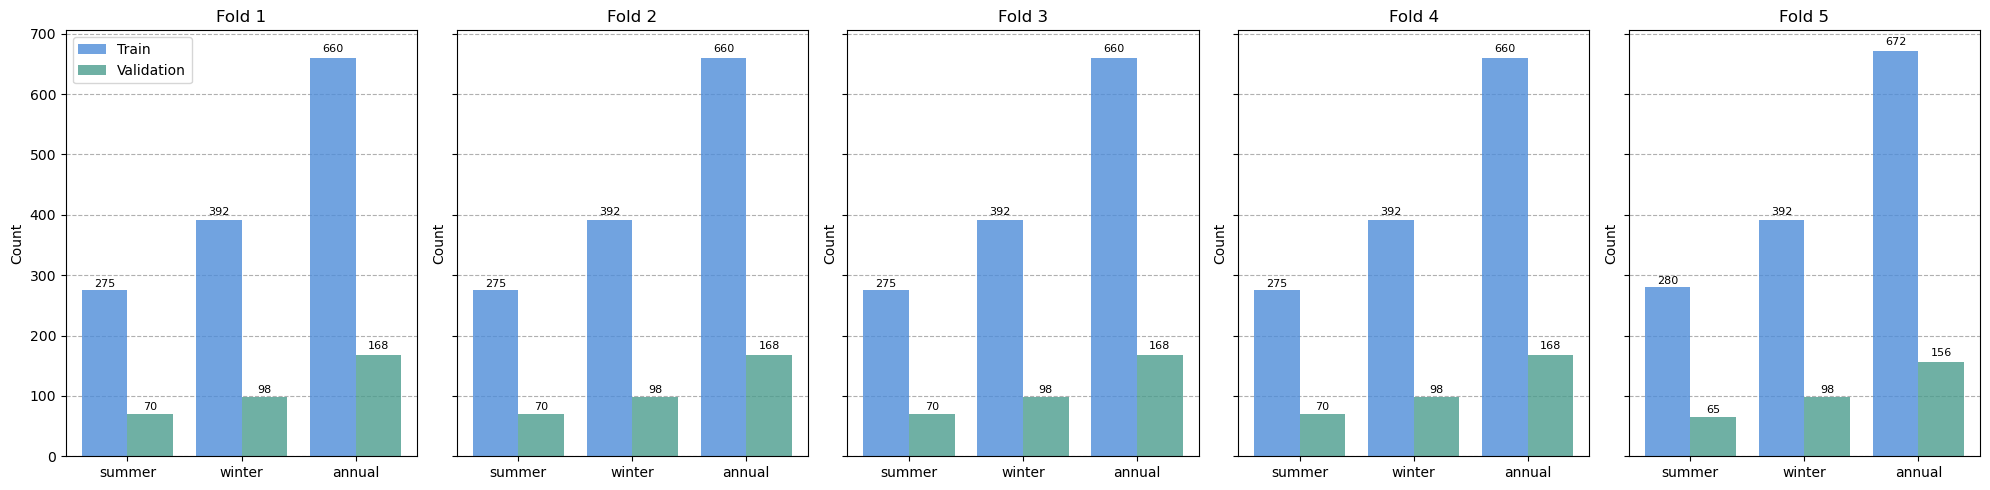

In [4]:
# Plot for each fold of the cross validation a histogram of the number of samples per period (annual, summer, winter) in the training and validation dataset. 
plot_fold_distribution(splits_train, df_X_train, PLOTTING)

## 2. Define the Custom Loss Function and XGBoost Regressor Function

Please see the following files for the custom loss function and the custom estimator class bases on XGBRegressor:
- ```model_methods.py``` -> ```custom_mse_metadata()```, will be used with the custom XGBRegressor class
- ```CustomXGBoostRegressor.py``` -> ```CustomXGBoostRegressor()```
    - TODO: modify ```def init()``` to retrieve keyword arguments for number of columns of metadata, with default = None, to allow for flexibility in the number of metadata columns. 

## 3. Model Training

### 3.1 Train XGBoost Model with Custom MSE Scorer and GridSearchCV (on a subset of the data)

In [5]:
# Define hyperparameter grid
# NOTE: Based on the defined parameter grid values for each learning parameter, user warnings may occur if one or more of the training scores are non-finite. This issue has not yet been resolved.
param_grid = {
    'max_depth': [3, 4, 5],#, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1],#, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma':[0]#, 1, 10],
    }

# Create a new XGBoostRegressor object that uses the custom loss function
xgb_model = CustomXGBoostRegressor(metadata_shape=3)

# IMPORTANT: n_jobs=-1 will use all the available cores. Please change to the desired number of cores.
clf = GridSearchCV(xgb_model, 
                   param_grid, 
                   cv=splits_train,
                   verbose=0, 
                   n_jobs=-1, 
                   refit=True, 
                   return_train_score=True) 

# Perform the cross validation for the provided parameter grid
clf.fit(X_train, y_train, verbose=False)

# Set the best model to the estimator that performed best in the gridsearch 
best_model = clf.best_estimator_

C:\Users\Jbies\anaconda3\envs\OGGM\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [-1.15888266e+00 -1.19135175e+00 -1.19840098e+00 -1.61230640e+00
 -1.60834244e+00 -1.60932545e+00 -1.75357531e+00 -1.75348776e+00
 -1.75401956e+00 -1.14311847e+31 -7.81800687e+59             nan
 -1.14333571e+31 -7.81880362e+59             nan -1.14333571e+31
 -7.81880362e+59             nan]
  warnings.warn(
C:\Users\Jbies\anaconda3\envs\OGGM\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the train scores are non-finite: [-2.55911122e-02 -4.27738363e-03 -8.13015887e-04 -4.78015724e-03
 -1.87995622e-04 -1.05851910e-05 -9.95031098e-04 -1.41146556e-05
 -3.14361389e-07 -1.17802443e+31 -8.11483565e+59             nan
 -1.17823971e+31 -8.11561939e+59             nan -1.17823971e+31
 -8.11561939e+59             nan]
  warnings.warn(


### 3.2 Plot the Score per Learning Parameter

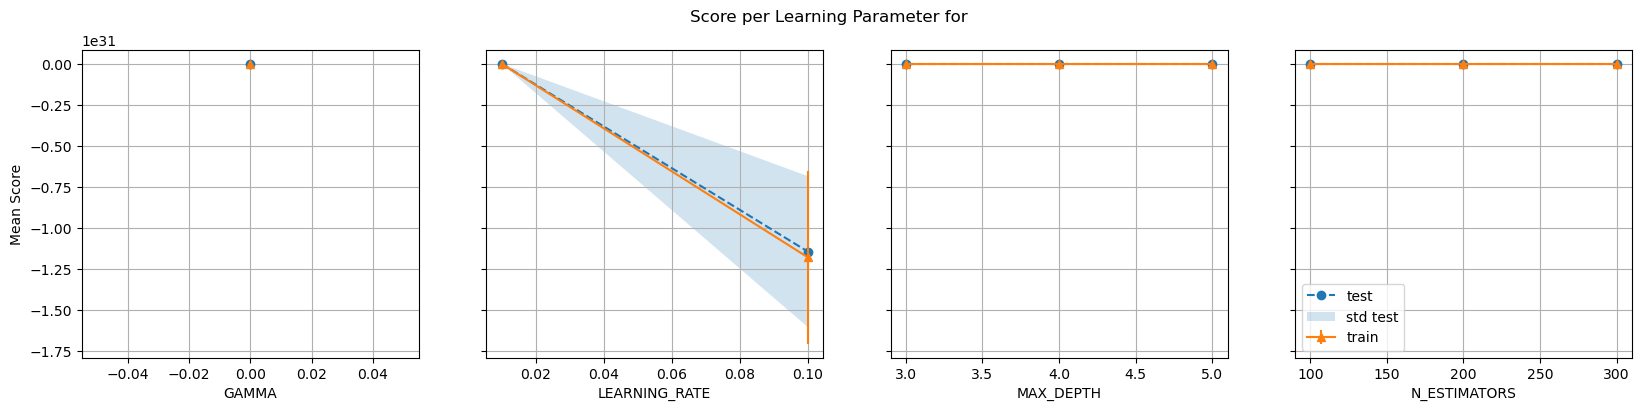

In [6]:
plot_gsearch_results(clf, '',PLOTTING) 

### 3.3 Plot the Results of the Grid Search per Fold

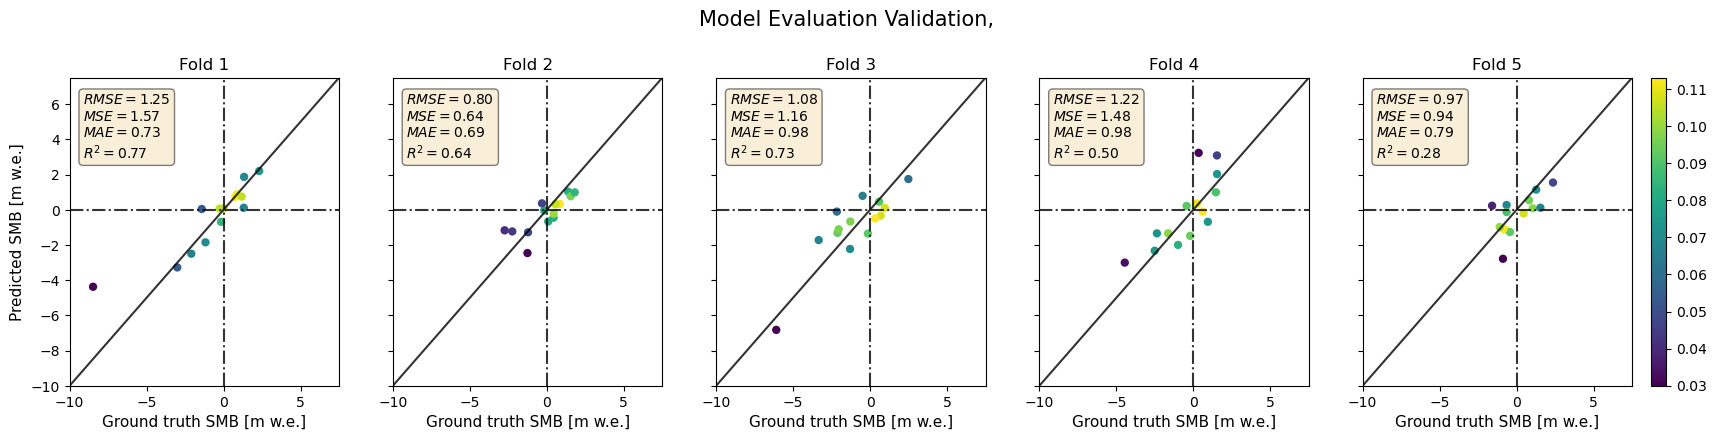

In [7]:
plot_prediction_validation(X_train, y_train, best_model, splits_train, '', PLOTTING, '')

### 3.3 Plot the Annual and Seasonal Aggregates of the Training Data

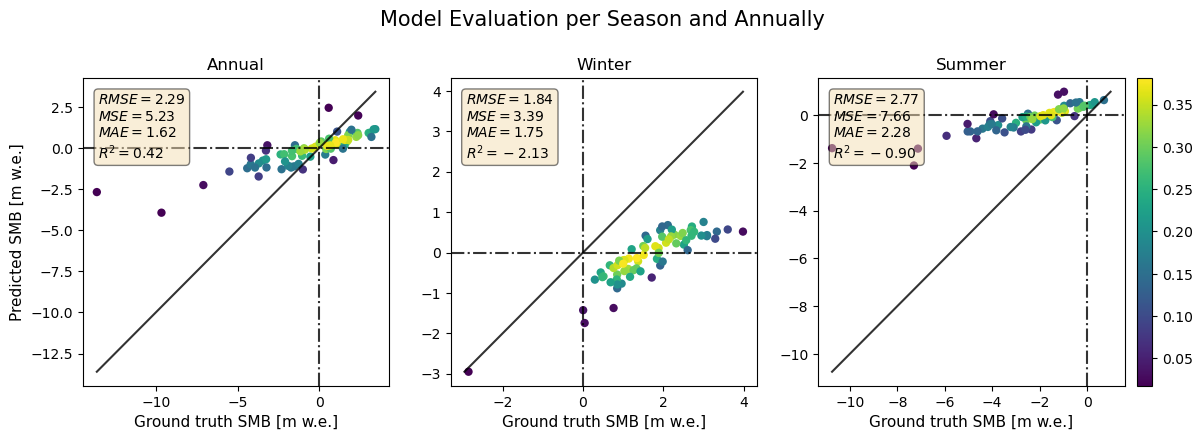

In [8]:
plot_prediction_per_season(PLOTTING, 'Train', X_train, y_train, splits_train, best_model)

## 4. Model Testing

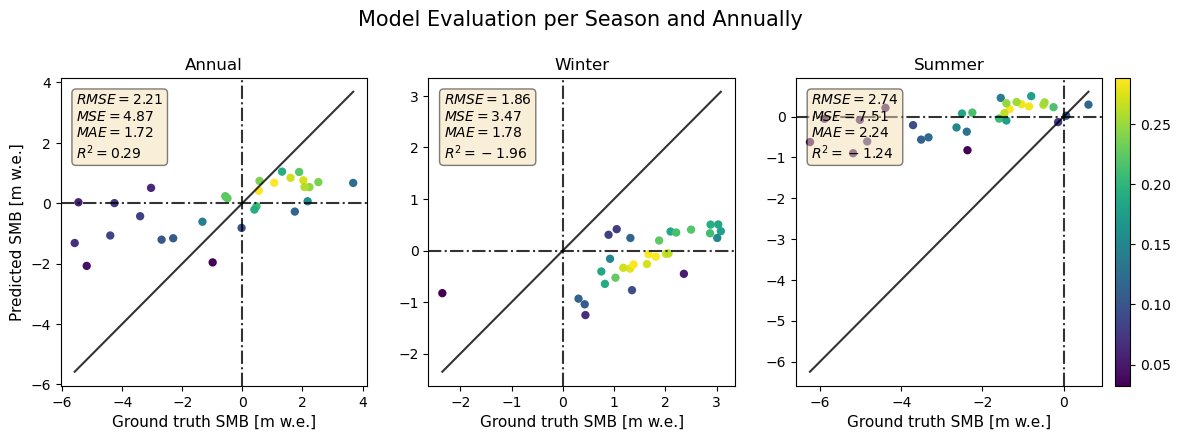

In [9]:
plot_prediction_per_season(PLOTTING, 'Test', X_test, y_test, splits_test, best_model)